

## Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterating through all folders, loading each image

trainAmt = 0.9
allFaces = []
labels = []

for i in tqdm(range(1, 41), desc="Subjects"):
    for j in tqdm(range(1, 11), desc=f"Subject {i}", leave=False):
        img_path = os.path.join('drive/MyDrive/ATnT', f"s{i}", f"{j}.pgm")
        img = cv2.imread(img_path, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

Subjects: 100%|██████████| 40/40 [02:45<00:00,  4.13s/it]

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [3]:
def principalComponentAnalysis(X, numComponents):
    # Flattening images
    X_flat = X.reshape(X.shape[0], -1)

    # Calculating mean face
    mean_face = np.mean(X_flat, axis=0)

    # Subtracting mean face
    X_centered = X_flat - mean_face

    # Computing covariance matrix
    cov_matrix = np.cov(X_centered,rowvar=False)

    # Performing eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sorting eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    # Selecting top components
    selected_eigenvectors = eigenvectors[:, :numComponents]

    # Projecting data onto selected eigenvectors
    eigen_projections = np.dot(X_centered, selected_eigenvectors)

    return mean_face, selected_eigenvectors, eigen_projections


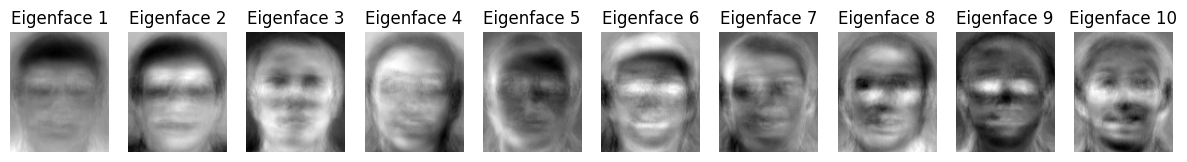

In [4]:
num_components = 100
mean_face, eigen_faces, _ = principalComponentAnalysis(trainFaces, num_components)

# Plotting the eigen faces
def plot_eigen_faces(eigen_faces, num_faces_to_plot=10):
    fig, axes = plt.subplots(1, num_faces_to_plot, figsize=(15, 5))
    for i in range(num_faces_to_plot):
        eigen_face_i = eigen_faces[:, i]
        eigen_face_i = (eigen_face_i - eigen_face_i.min()) / (eigen_face_i.max() - eigen_face_i.min())
        axes[i].imshow(eigen_face_i.reshape(112, 92), cmap='gray')
        axes[i].set_title(f'Eigenface {i+1}')
        axes[i].axis('off')
    plt.show()

plot_eigen_faces(eigen_faces)

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [5]:
def imageReconstruction(test_face, eigen_faces, mean_face):
    # Flattening test face
    test_face_flat = test_face.flatten()

    # Subtracting mean face
    test_face_centered = test_face_flat - mean_face

    # Projecting onto eigenfaces
    weights = np.dot(test_face_centered, eigen_faces)

    # Reconstructing face
    reconstructed_face = mean_face + np.dot(weights, eigen_faces.T)

    # Reshaping reconstructed face
    reconstructed_face = reconstructed_face.reshape(test_face.shape)

    return reconstructed_face


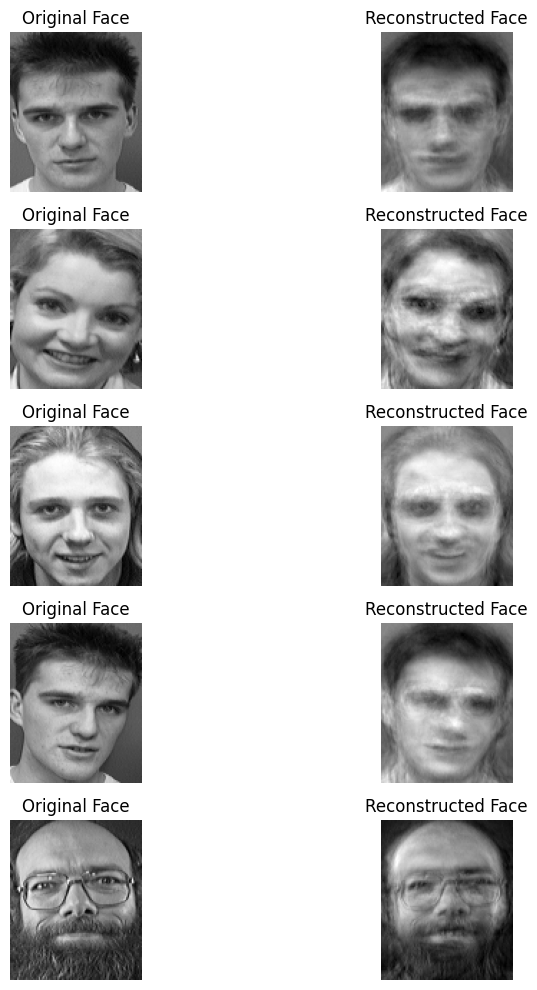

In [6]:
def plot_reconstructions(test_faces, reconstructed_faces, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 2*num_examples))
    for i in range(num_examples):
        axes[i, 0].imshow(test_faces[i], cmap='gray')
        axes[i, 0].set_title('Original Face')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed_faces[i], cmap='gray')
        axes[i, 1].set_title('Reconstructed Face')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

num_examples = 10
test_faces_to_reconstruct = testFaces[:num_examples]
reconstructed_faces = []
for test_face in test_faces_to_reconstruct:
    reconstructed_face = imageReconstruction(test_face, eigen_faces, mean_face)
    reconstructed_faces.append(reconstructed_face)

plot_reconstructions(test_faces_to_reconstruct, reconstructed_faces)

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

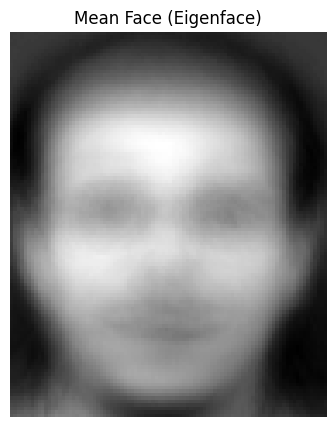

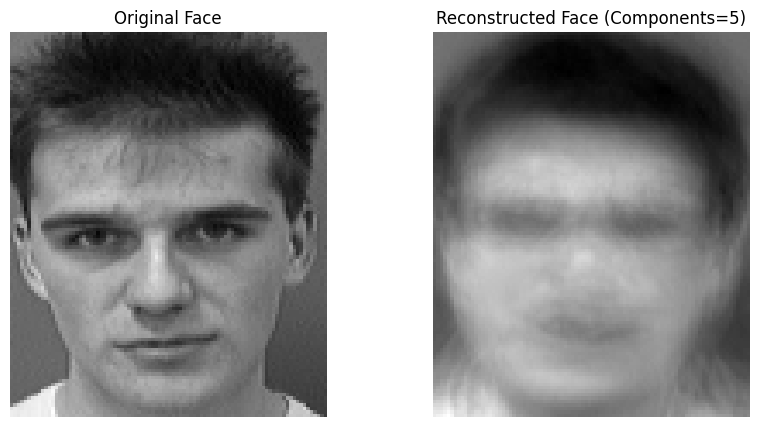

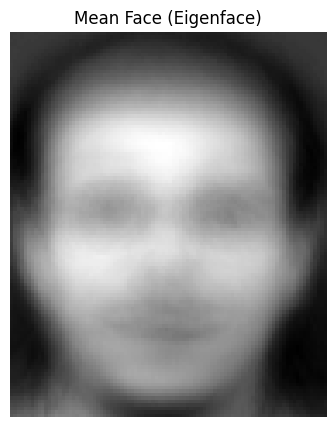

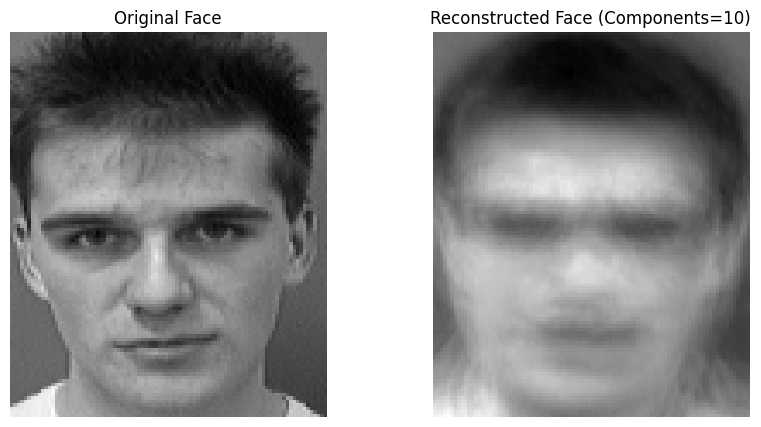

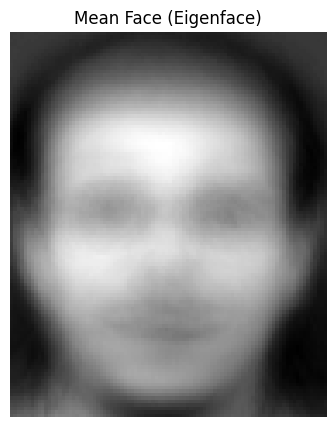

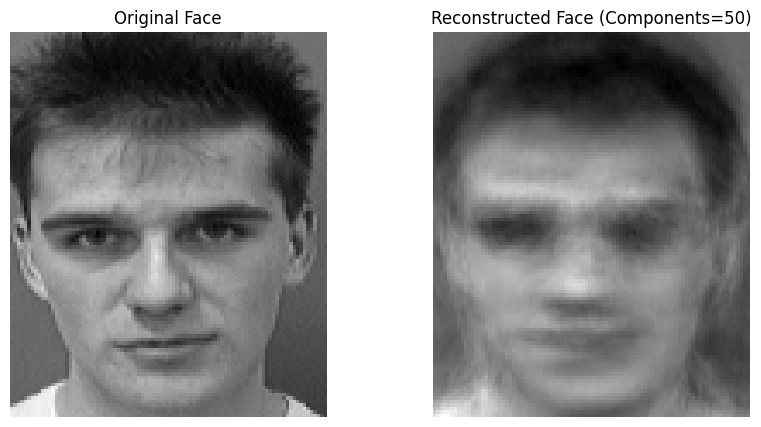

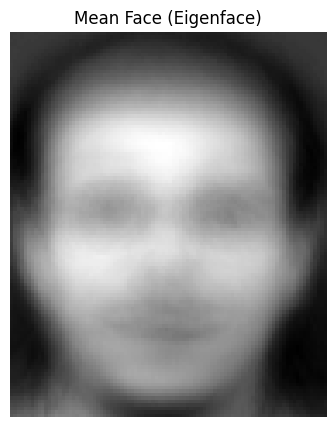

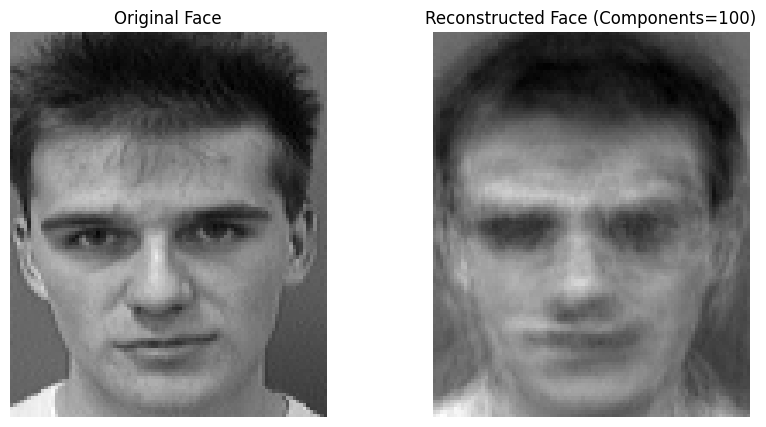

In [7]:
# Visualizing results for different numbers of components
def display_n_factors(train_faces, num_components_list):
    for num_components in num_components_list:
        mean_face, eigen_faces, _ = principalComponentAnalysis(train_faces, num_components)

        # Plotting the mean face
        plt.figure(figsize=(5, 5))
        plt.imshow(mean_face.reshape(112, 92), cmap='gray')  # Reshaping to original dimensions
        plt.title('Mean Face (Eigenface)')
        plt.axis('off')
        plt.show()

        # Plotting reconstruction of the first test face
        test_face = testFaces[0]
        reconstructed_face = imageReconstruction(test_face, eigen_faces, mean_face)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(test_face.reshape(112, 92), cmap='gray')  # Reshaping to original dimensions
        plt.title('Original Face')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_face.reshape(112, 92), cmap='gray')  # Reshaping to original dimensions
        plt.title(f'Reconstructed Face (Components={num_components})')
        plt.axis('off')
        plt.show()


num_components_list = [5, 10, 50, 100]
display_n_factors(trainFaces, num_components_list)



#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

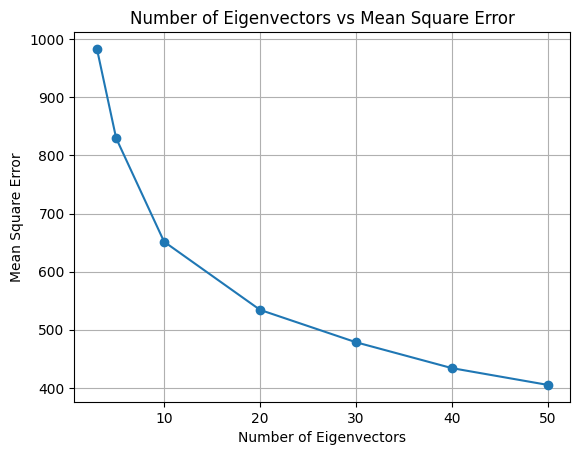

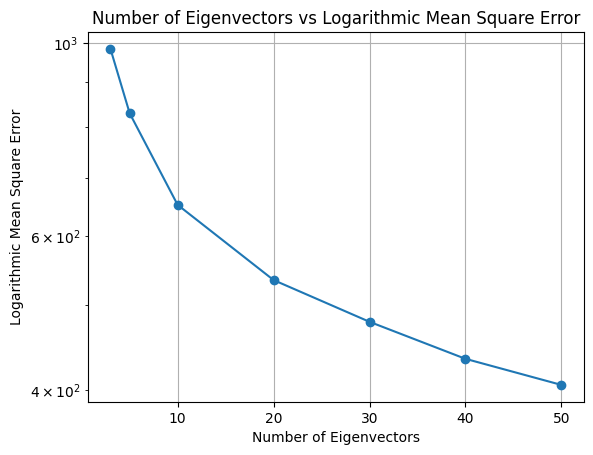

In [8]:
# Implementing face recognition module based on the norm
def get_class(test_face, eigen_faces, mean_face, train_faces, train_labels):
    # Flattening test face
    test_face_flat = test_face.flatten()

    # Subtracting mean face
    test_face_centered = test_face_flat - mean_face

    # Projecting onto eigenfaces
    weights = np.dot(test_face_centered, eigen_faces)

    # Reconstructing face
    reconstructed_face = mean_face + np.dot(weights, eigen_faces.T)

    # Reshaping reconstructed face
    reconstructed_face = reconstructed_face.reshape(test_face.shape)

    # Calculating errors and finding closest match
    errors = np.linalg.norm(train_faces.reshape(train_faces.shape[0], -1) - reconstructed_face.flatten(), axis=1)
    min_error_idx = np.argmin(errors)
    predicted_label = train_labels[min_error_idx]

    return train_faces[min_error_idx], errors[min_error_idx], predicted_label



def test_face_recognition(train_faces, train_labels, test_faces, test_labels, num_components_list):
    accuracies = []
    for num_components in num_components_list:
        mean_face, eigen_faces, _ = principalComponentAnalysis(train_faces, num_components)
        correct_predictions = 0
        for i, test_face in enumerate(test_faces):
            _, _, predicted_label = get_class(test_face, eigen_faces, mean_face, train_faces, train_labels)
            if predicted_label == test_labels[i]:
                correct_predictions += 1
        accuracy = correct_predictions / len(test_faces)
        accuracies.append(accuracy)
    return accuracies


# Ploting Number of eigenvectors vs Mean Square Error Plot Number of eigenvectors vs Logarithmic Mean Square Error
def plot_mse(num_components_list, mse):
    plt.plot(num_components_list, mse, marker='o')
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Mean Square Error')
    plt.title('Number of Eigenvectors vs Mean Square Error')
    plt.grid(True)
    plt.show()

def plot_log_mse(num_components_list, mse):
    plt.semilogy(num_components_list, mse, marker='o')
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Logarithmic Mean Square Error')
    plt.title('Number of Eigenvectors vs Logarithmic Mean Square Error')
    plt.grid(True)
    plt.show()


# Calculating MSE for each number of components
def calculate_mse(train_faces, test_faces, num_components_list):
    mse_list = []
    for num_components in num_components_list:
        mean_face, eigen_faces, _ = principalComponentAnalysis(train_faces, num_components)
        mse_sum = 0
        for test_face in test_faces:
            reconstructed_face = imageReconstruction(test_face, eigen_faces, mean_face)
            mse_sum += np.mean((test_face - reconstructed_face) ** 2)
        mse_list.append(mse_sum / len(test_faces))
    return mse_list



num_components_list = [3,5,10,20,30,40,50]
mse_values = calculate_mse(trainFaces, testFaces, num_components_list)
plot_mse(num_components_list, mse_values)
plot_log_mse(num_components_list, mse_values)

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [9]:
components = [3, 5, 10, 20, 30, 40, 50]
accuracies = []

for num_components in components:
    accuracy = test_face_recognition(trainFaces, trainLabels, testFaces, testLabels, [num_components])
    accuracies.append(accuracy[0])

for num_components, accuracy in zip(components, accuracies):
    print(f"Number of components: {num_components}, Accuracy: {accuracy}")

Number of components: 3, Accuracy: 0.2
Number of components: 5, Accuracy: 0.35
Number of components: 10, Accuracy: 0.75
Number of components: 20, Accuracy: 0.9
Number of components: 30, Accuracy: 0.925
Number of components: 40, Accuracy: 0.95
Number of components: 50, Accuracy: 0.95
